<a href="https://colab.research.google.com/github/gustafarsoares23/Tech-Challenge-ML/blob/main/Tech_Challengfe_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prevendo valores do IBOVESPA com algoritmos de machine learning**

O objetivo deste estudo é conduzir quatro tipos de testes de previsão de séries temporais!

Utilizaremos dois modelos tradicionais (média móvel e ARIMA), e também um modelo mais robusto (Prophet do Facebook - Meta)

## **Sobre o dataset**

O dataset é composto pelo histórico do valor das ações do *IBOVESPA* dentro do período de 01/01/2014 a 25/01/2024.

O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.

Reavaliado a cada quatro meses, o índice é resultado de uma carteira teórica de ativos. É composto pelas ações e units de companhias listadas na B3 que atendem aos critérios descritos na sua metodologia, correspondendo a cerca de 80% do número de negócios e do volume financeiro do nosso mercado de capitais.

Link para acessar os dados do IBOVESPA: https://br.investing.com/indices/bovespa-historical-data

## Importando as Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

## Importando o Dataset

### Importando e checando os dados

In [ ]:
# Importando a base de dados, já ajustando a coluna Data para ser o index
dados = pd.read_csv('Dados_Historicos_Ibovespa.csv', sep=",")

In [ ]:
# Verificando os dados
dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25.01.2024,128.06,127.81,128.70,127.80,"7,54M","0,19%"
1,24.01.2024,127.82,128.28,129.45,127.68,"8,82M","-0,35%"
2,23.01.2024,128.26,126.61,128.33,126.61,"9,37M","1,31%"
3,22.01.2024,126.60,127.64,127.84,126.12,"9,51M","-0,81%"
4,19.01.2024,127.64,127.32,127.82,126.53,"11,96M","0,25%"


In [ ]:
dados.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
2489,08.01.2014,50.58,50.43,50.79,50.42,"2,92M","0,29%"
2490,07.01.2014,50.43,50.98,51.48,50.43,"3,34M","-1,07%"
2491,06.01.2014,50.97,50.98,51.00,50.45,"3,73M","-0,01%"
2492,03.01.2014,50.98,50.35,50.98,50.27,"7,36M","1,27%"
2493,02.01.2014,50.34,51.52,51.66,50.25,"3,48M","-2,26%"


### Alterando o nome das colunas

In [ ]:
# Renomeando as colunas para facilitar os códigos:
dados.rename(columns={'Data': 'data', 'Último': 'ultimo', 'Abertura': 'abertura', 'Máxima': 'maxima', 'Mínima': 'minima', 'Vol.': 'volume', 'Var%': 'variacao%'}, inplace=True)

In [ ]:
# Verificando os dados
dados.head()

,data,ultimo,abertura,maxima,minima,volume,variacao%
0,25.01.2024,128.06,127.81,128.70,127.80,"7,54M","0,19%"
1,24.01.2024,127.82,128.28,129.45,127.68,"8,82M","-0,35%"
2,23.01.2024,128.26,126.61,128.33,126.61,"9,37M","1,31%"
3,22.01.2024,126.60,127.64,127.84,126.12,"9,51M","-0,81%"
4,19.01.2024,127.64,127.32,127.82,126.53,"11,96M","0,25%"


### Transformando a coluna data em Datetime

In [ ]:
dados['data'] = pd.to_datetime(dados['data'], format='%d.%m.%Y')

In [ ]:
# Verificando os dados
dados.head()

,data,ultimo,abertura,maxima,minima,volume,variacao%
0,2024-01-25,128.06,127.81,128.70,127.80,"7,54M","0,19%"
1,2024-01-24,127.82,128.28,129.45,127.68,"8,82M","-0,35%"
2,2024-01-23,128.26,126.61,128.33,126.61,"9,37M","1,31%"
3,2024-01-22,126.60,127.64,127.84,126.12,"9,51M","-0,81%"
4,2024-01-19,127.64,127.32,127.82,126.53,"11,96M","0,25%"


### Colocando a coluna data como index

In [ ]:
dados.set_index('data', inplace=True)

In [ ]:
# Verificando os dados
dados.head()

,ultimo,abertura,maxima,minima,volume,variacao%
data,,,,,,
2024-01-25,128.06,127.81,128.70,127.80,"7,54M","0,19%"
2024-01-24,127.82,128.28,129.45,127.68,"8,82M","-0,35%"
2024-01-23,128.26,126.61,128.33,126.61,"9,37M","1,31%"
2024-01-22,126.60,127.64,127.84,126.12,"9,51M","-0,81%"
2024-01-19,127.64,127.32,127.82,126.53,"11,96M","0,25%"


In [ ]:
type(dados)

pandas.core.frame.DataFrame

## Visualizando os valores de fechamento

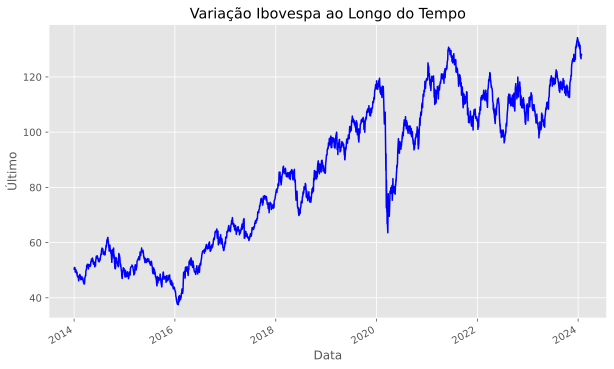

In [ ]:
dados['ultimo'].plot(figsize=(10, 6), linestyle='-', color='b')

# Adicionando rótulos e título ao gráfico
plt.title('Variação Ibovespa ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Último')

# Exibindo o gráfico
plt.show()

## Criando um Dataset final

### Excluindo colunas desnecessárias

In [ ]:
df_limpo = dados.drop(['abertura', 'maxima', 'minima', 'volume', 'variacao%'], axis=1).copy()
df_limpo.index = pd.DatetimeIndex(df_limpo.index) # transformando em DatetimeIndex para usar seasonal_decompose
df_limpo.head()

,ultimo
data,
2024-01-25,128.06
2024-01-24,127.82
2024-01-23,128.26
2024-01-22,126.60
2024-01-19,127.64


In [ ]:
type(df_limpo.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
df_limpo.loc['2024-01-24']

ultimo   127.82
Name: 2024-01-24 00:00:00, dtype: float64

## Decomposição para Análise da série temporal

### Utilizaremos o Statsmodel para decompor a série em:

* Tendência, que é a direção da série temporal.
* Sazonalidadem, que são os padrões repetidos no tempo.
* Ruído, que é a diferença entre a série original e o explicado por tendência e sazonalidade.


### Importância da Decomposição:
A decomposição auxilia na compreensão dos dados e na escolha do modelo preditivo, permitindo:

* Previsões de longo prazo ao compreender a tendência.
* Previsões de curto prazo ao entender a sazonalidade.
* Melhora nos modelos ao analisar os resíduos não capturados.

### Série Aditiva ou Multiplicativa:
A decomposição indica se a série é:

* Aditiva: Magnitude de sazonalidade e tendência constante.
* Multiplicativa: Magnitude varia proporcionalmente ao nível da série.

In [ ]:
resultados = seasonal_decompose(df_limpo, model='multiplicative', period=5) # Period = sazonaliade. Como temos dados de segunda a sexta, então temos 5, referentes aos 5 dias

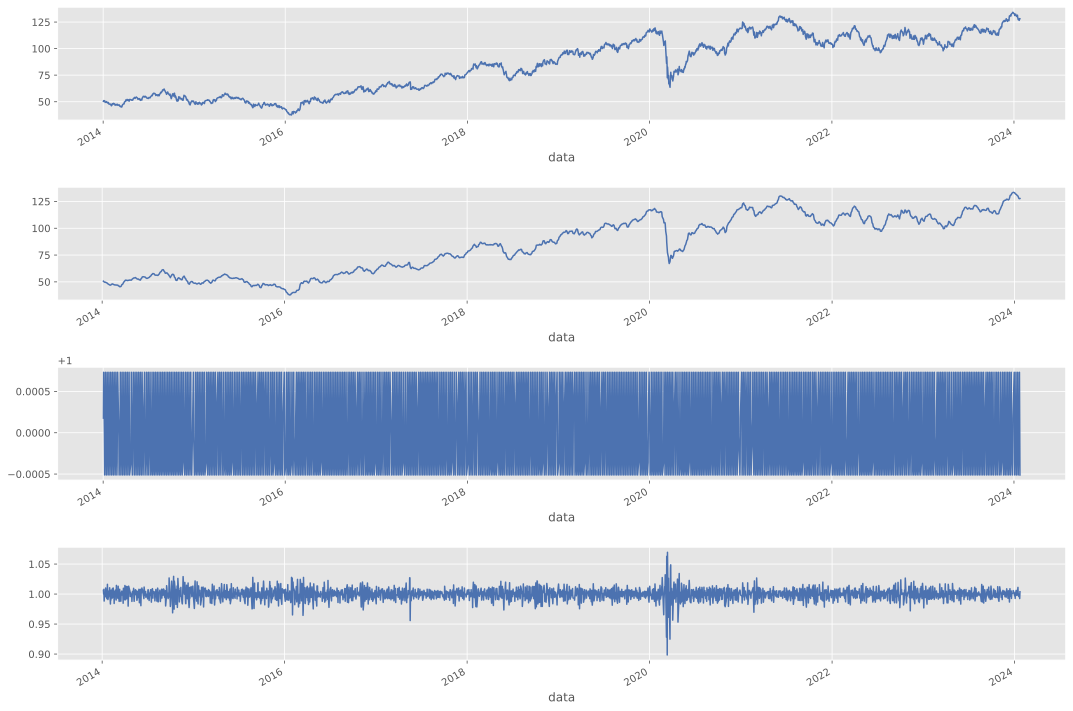

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1) # Serie dos dados
resultados.trend.plot(ax=ax2) # tendência dos dados
resultados.seasonal.plot(ax=ax3) # sazonalidade
resultados.resid.plot(ax=ax4) # resíduos

plt.tight_layout()

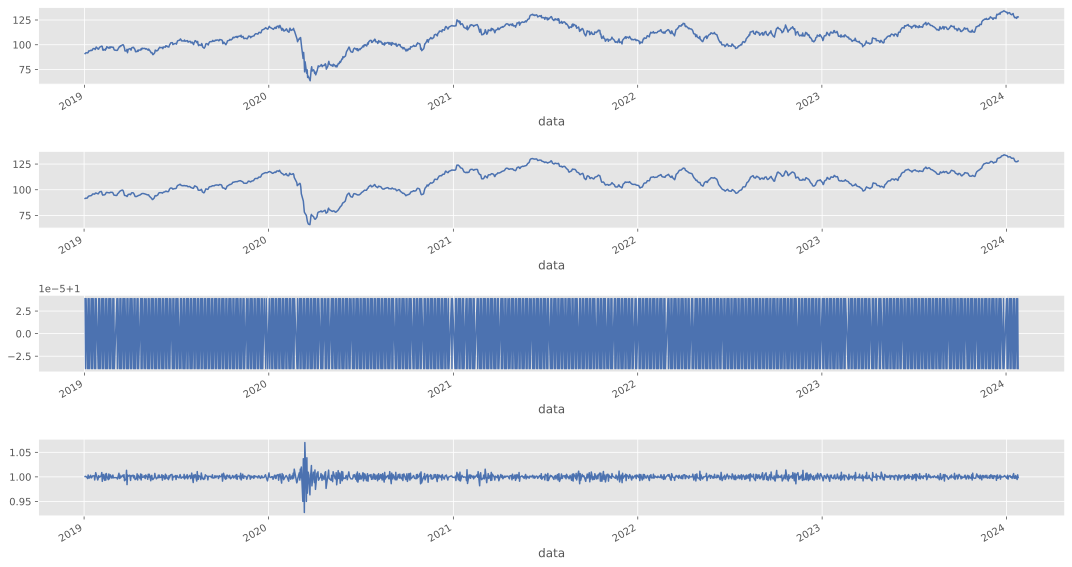

In [ ]:
df_5_anos = df_limpo.loc['2019-01-01':]
seasonplot = seasonal_decompose(df_5_anos, model='multiplicative', period=2)  # decompondo a série temporal

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # série real
seasonplot.trend.plot(ax=ax2)  # tendência
seasonplot.seasonal.plot(ax=ax3)  # sazonalidade
seasonplot.resid.plot(ax=ax4)  # resíduos
plt.tight_layout()
plt.show()

## Ações estão subindo?

Se notarmos a 1ª decomposição, com todos os 10 anos de dados que temos, podemos assumir, que **SIM**, as ações do IBOVESPA estão subindo ao longo dos anos.

Porém, na segunda decomposição, optei por decompor apenas os últimos 5 anos de valores do IBOVESPA, e aqui, as coisas ficam um pouco mais interessante, pois podemos perceber que o Ibovespa está com pouca variação e isso pode ser atribuído a uma combinação de fatores, incluindo:

* Diversificação do Índice: Como mencionado anteriormente, o Ibovespa é composto por ações de várias empresas de setores diferentes. Isso ajuda a suavizar as flutuações, já que eventos específicos que afetam uma empresa podem ser compensados por desempenhos positivos em outras.

* Resistência a Choques: A diversificação e a ponderação pelo valor de mercado também conferem resistência a choques. Grandes movimentos em uma única ação podem ter um impacto limitado no índice como um todo.

* Maturidade do Mercado: Mercados mais maduros tendem a ter uma estabilidade maior, pois os investidores estão mais informados e as práticas de investimento são mais desenvolvidas.

* Regulação Financeira: A presença de regulamentações sólidas pode contribuir para a estabilidade do mercado, fornecendo regras e procedimentos que ajudam a prevenir práticas abusivas e manipulações.

* Expectativas dos Investidores: Se os investidores têm expectativas de estabilidade de longo prazo, isso pode influenciar seu comportamento, reduzindo a propensão a reações exageradas a eventos de curto prazo.

Logo, aqui já podemos concluir que, se fizéssemos alguns testes de estacionariedade com os últimos 5 anos, provavelmente obteríamos uma serie estacionária logo de cara. Por isso, optei por trabalhar com os últimos 10 anos dessa ação, pois sei que o IBOVESPA tende a não variar muito, pelos motivos já explicados acima, mas que ele varia sim, porém demora um pouco mais, então precisávamos de mais anos.

## **Testando Modelos de Machine Learning Clássicos**

### **Média Móvel**

A média móvel é uma técnica estatística utilizada na análise de séries temporais e dados financeiros para suavizar flutuações aleatórias e identificar tendências ao longo do tempo. A ideia básica por trás da média móvel é calcular, para cada ponto de dados em uma série temporal, a média dos pontos de dados vizinhos.

Vamos utilizar esta técnica para um N de 10 e de 20 dias.

In [ ]:
df_limpo_MA = df_limpo.copy()  # criando uma cópia do DataFrame original

# Adicionando colunas ao DataFrame copiado
df_limpo_MA['MA_window_10'] = df_limpo_MA['ultimo'].rolling(10).mean().shift()  # média móvel em 10 dias
df_limpo_MA['MA_window_20'] = df_limpo_MA['ultimo'].rolling(20).mean().shift()  # média móvel em 20 dias


#Rolling para deslocamento. Este parâmetro especifica o número de observações usadas para calcular a estatística
#shift é utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo

In [ ]:
df_limpo_MA.head(20)

,ultimo,MA_window_10,MA_window_20
data,,,
2024-01-25,128.06,NaN,NaN
2024-01-24,127.82,NaN,NaN
2024-01-23,128.26,NaN,NaN
2024-01-22,126.60,NaN,NaN
2024-01-19,127.64,NaN,NaN
2024-01-18,127.32,NaN,NaN
2024-01-17,128.52,NaN,NaN
2024-01-16,129.29,NaN,NaN
2024-01-15,131.52,NaN,NaN


### Vizualizando o Resultado

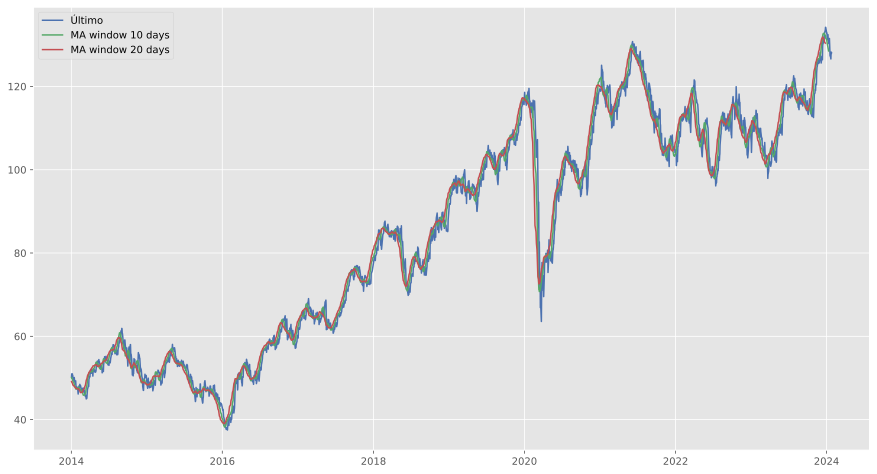

In [ ]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(df_limpo_MA['ultimo'], label='Último')
plt.plot(df_limpo_MA['MA_window_10'], label='MA window 10 days')
plt.plot(df_limpo_MA['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Visualizando os dados mais recentes: últimos 365 dias

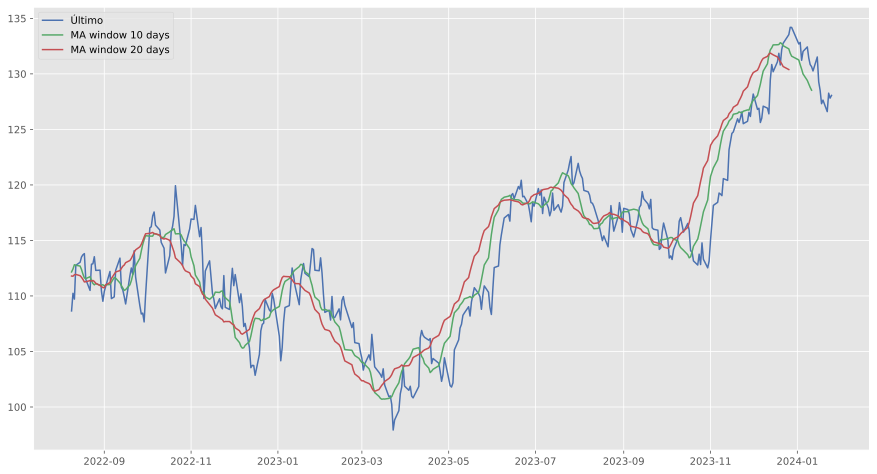

In [ ]:
import matplotlib.pyplot as plt

# Ordenando o DataFrame pela coluna de datas
df_limpo_MA = df_limpo_MA.sort_index(ascending=True)

# Pegando os últimos 300 dias a partir da data mais recente
df_ultimos_300_dias = df_limpo_MA.tail(365)

plt.figure(figsize=(15, 8))
plt.grid(True)

plt.plot(df_ultimos_300_dias['ultimo'], label='Último')
plt.plot(df_ultimos_300_dias['MA_window_10'], label='MA window 10 days')
plt.plot(df_ultimos_300_dias['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Prevendo os "N" dias com base na média móvel aritmética

In [ ]:
df_limpo_MA['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [ ]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [ ]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df_limpo_MA), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df_limpo_MA):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df_limpo_MA['ultimo'].iloc[window_close], df_limpo_MA['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df_limpo_MA.iat[index + i, df_limpo_MA.columns.get_loc('MA_window_10_forward_10')] = mean

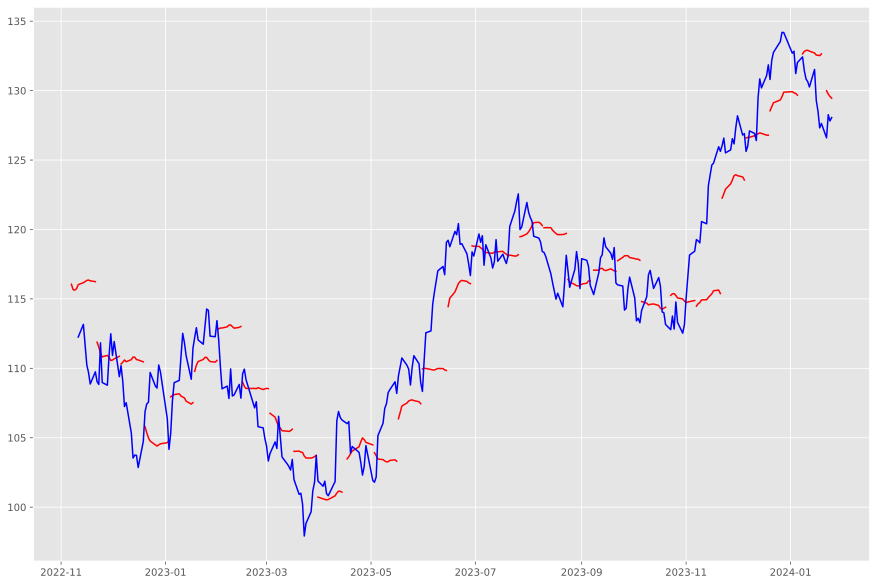

In [ ]:
limit = 300

plt.figure(figsize = (15,10))

size = len(df_limpo_MA)-limit - (len(df_limpo_MA)-limit)%forward_days

for index in range(size, len(df_limpo_MA), forward_days):
    plt.plot(df_limpo_MA['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df_limpo_MA['ultimo'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

Cada reta vermelha representa uma previsão de 10 dias, tomando como base os 10 dias anteriores. Por isso elas são descontínuas.

Apesar de ser um modelo mais clássico, ele é bem simples, pois tem como objetivo prever N dias a frente para ver qual será o comportamento da ação.

Como vimos aqui, essa metodologia não deu certo, então vamos testar o outro Clássico, o ARIMA.

## Testando o modelo ARIMA 💹
ARIMA significa Média Móvel Integrada Auto-Regressiva.

Um modelo ARIMA é uma classe de modelos estatísticos para analisar e prever dados de séries temporais. Enquanto os modelos de suavização exponencial são baseados na descrição da tendência e sazonalidade dos dados, os modelos ARIMA visam descrever as autocorrelações nos dados.

O algoritmo ARIMA utiliza autoregressão + médias móveis + diferenciação.

Os termos autoregressivos permitem que o modelo capture a influência dos valores passados na série temporal. Os termos de média móvel permitem que o modelo capture os erros de previsão passados. A diferenciação permite que o modelo capture tendências na série temporal.

❗ Antes de falarmos sobre o modelo ARIMA, vamos falar sobre o conceito de estacionariedade e a técnica de diferenciação de séries temporais.

O que é estacionaridade? 🤔

Para trabalhar com séries temporais utilizando o modelo ARIMA, precisamos que ela seja estacionária. Essa característica além de ser necessária para algum modelos, facilita a projeção dos dados. Portanto é considerado uma série estacionaria aquela série que em *certos períodos possui a mesma média*.

A tendência e a sazonalidade afetarão o valor da série temporal em momentos diferentes. Por outro lado, para a estacionaridade, não importa quando você a observa, ela deve parecer a mesma em qualquer momento. Em geral, uma série temporal estacionária não terá padrões previsíveis no longo prazo.

Hiperparâmetros do algortimo:
P - Número de lags que devem ser incluídos no modelo (lags são valores auto correlacionados que devem ser levados em consideração, ou seja, os valores históricos que serão utilizados para prever o futuro.)
D - Número de vezes que as observações serão diferenciadas. (tornar a série estacionária)
Q - Ordem de média móvel, tamanho de uma janela (lag) de média móvel.(para calcular o erro e encontrar a melhor previsão (tamanho da janela da media móvel) para calcular os residuos e fazer o forecast).
Passos para aplicar o ARIMA:
Visualize os dados da série temporal 📈
Identifique se a data é estacionária ✅
Plote os gráficos de correlação e autocorrelação 🤔
Construir o modelo ARIMA com base nos dados 🔨
Analisando a correlação dos dados:
Ao trabalhar com modelos ARIMA, uma etapa importante é entender a autocorrelação presente nos dados. A autocorrelação refere-se à correlação de uma série temporal com uma versão atrasada de si mesma. Para entender e visualizar essa autocorrelação, utilizamos as funções de autocorrelação (ACF) e autocorrelação parcial (PACF).

Autocorrelação e Autocorrelação parcial:
ACF (autocorrelação) temos a correlação direta e indireta.
PACF (autocorrelação parcial): apenas a correlação direta.
A ACF é uma ferramenta valiosa para entender padrões de dependência temporal nos dados. Os lags são os intervalos de atraso entre as observações. Cada ponto no gráfico indica a correlação entre a série temporal e ela mesma em diferentes pontos no passado.

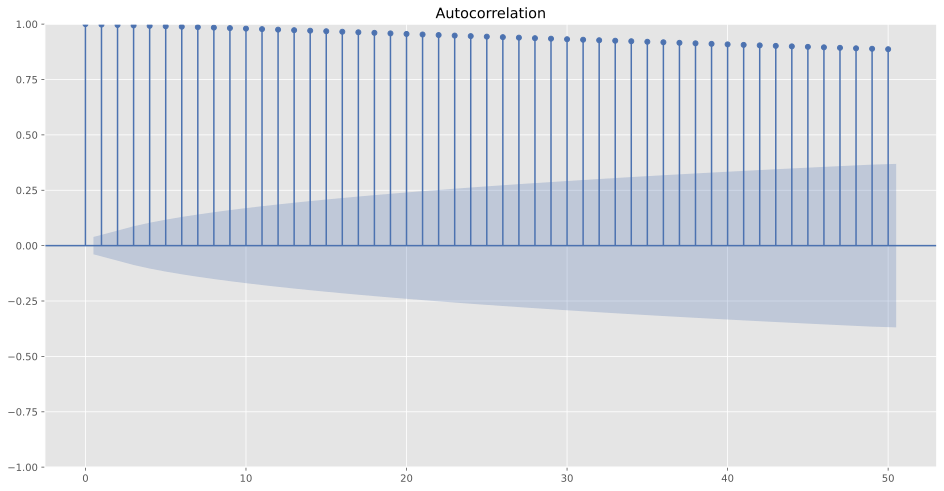

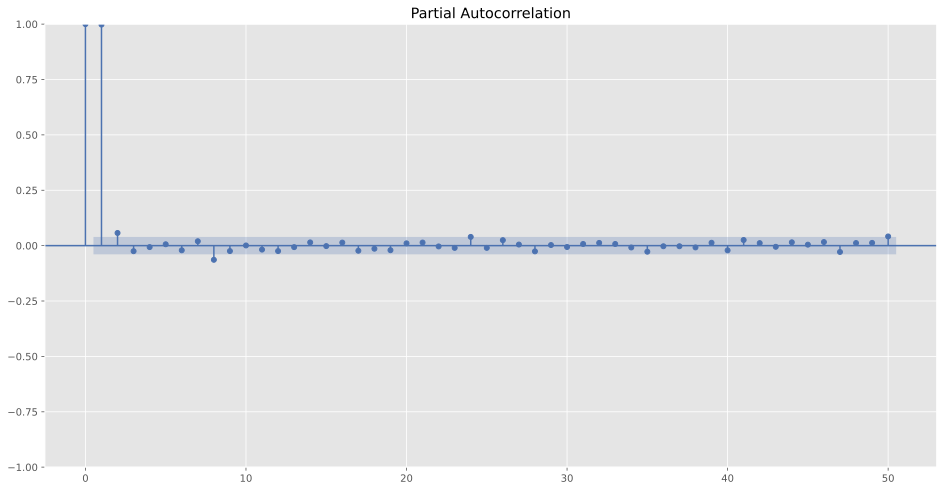

In [ ]:
# Plotando a ACF
plot_acf(df_limpo['ultimo'], lags=50)

# Plotando a PACF
plot_pacf(df_limpo['ultimo'], lags=50)

plt.show()

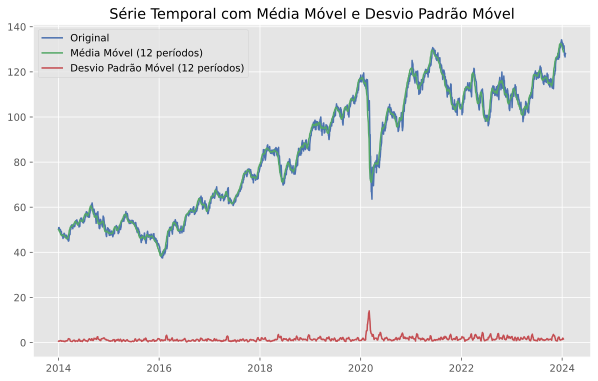

In [ ]:
window_size = 12  # ajuste conforme necessário

# Calculando a média móvel e o desvio padrão
rolling_mean = df_limpo['ultimo'].rolling(window=window_size).mean()
rolling_std = df_limpo['ultimo'].rolling(window=window_size).std()

# Plotando a série temporal original, média móvel e desvio padrão
plt.figure(figsize=(10, 6))
plt.plot(df_limpo['ultimo'], label='Original')
plt.plot(rolling_mean, label=f'Média Móvel ({window_size} períodos)')
plt.plot(rolling_std, label=f'Desvio Padrão Móvel ({window_size} períodos)')

plt.title('Série Temporal com Média Móvel e Desvio Padrão Móvel')
plt.legend()
plt.show()


In [ ]:
# Função para realizar o Teste de Dickey-Fuller e imprimir os resultados
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')

    print('Resultado do Teste de Dickey-Fuller:')
    print('Estatística do Teste:', result[0])
    print('Valor p:', result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    # Tomar uma decisão com base no valor p
    if result[1] <= 0.05:
        print("\nResultado: A série é estacionária.")
    else:
        print("\nResultado: A série não é estacionária.")

# Aplicar o Teste de Dickey-Fuller na série temporal original
adf_test(df_limpo['ultimo'].dropna())

Resultado do Teste de Dickey-Fuller:
Estatística do Teste: -1.4764166723788021
Valor p: 0.5451437523440054
Valores Críticos:
   1%: -3.4329831717881003
   5%: -2.8627033184297384
   10%: -2.5673892799386944

Resultado: A série não é estacionária.


### Transformando em estacionairia

In [ ]:
df_limpo.head()

,ultimo
data,
2024-01-25,128.06
2024-01-24,127.82
2024-01-23,128.26
2024-01-22,126.60
2024-01-19,127.64


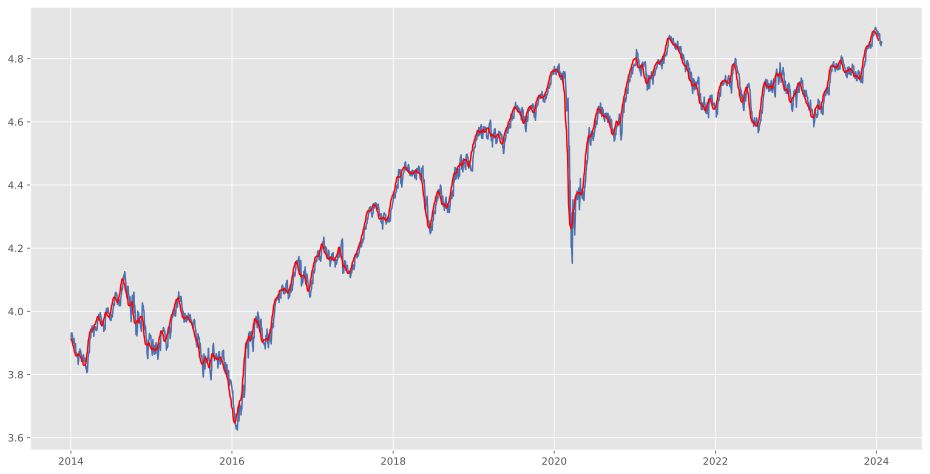

In [ ]:
#Estimating trend
df_limpo_log = np.log(df_limpo) #Transformação logarítma

# Calculando a média móvel
ma = df_limpo_log.rolling(window=12).mean()
mstd = df_limpo_log.rolling(window=12).std()

# Plotando
plt.plot(df_limpo_log)
plt.plot(ma, color='red')

In [ ]:
df_limpo_log_minus_ma = df_limpo_log - ma
df_limpo_log_minus_ma.head(12)

#Remove NAN values
df_limpo_log_minus_ma.dropna(inplace=True)

In [ ]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    ma = timeseries.rolling(window=12).mean()
    mstd = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(ma, color='red', label='Rolling Mean')
    std = plt.plot(mstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['ultimo'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

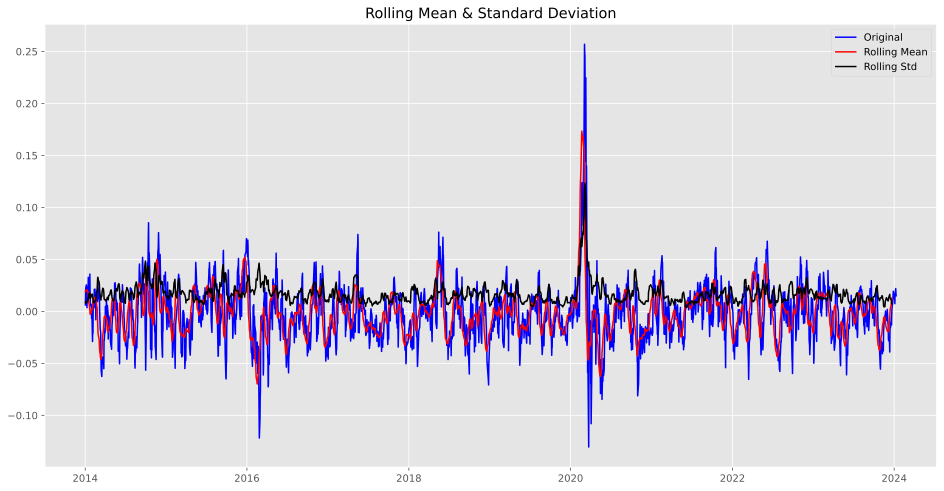

Results of Dickey Fuller Test:
Test Statistic                  -12.84
p-value                           0.00
#Lags Used                        7.00
Number of Observations Used   2,475.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


In [ ]:
test_stationarity(df_limpo_log_minus_ma)

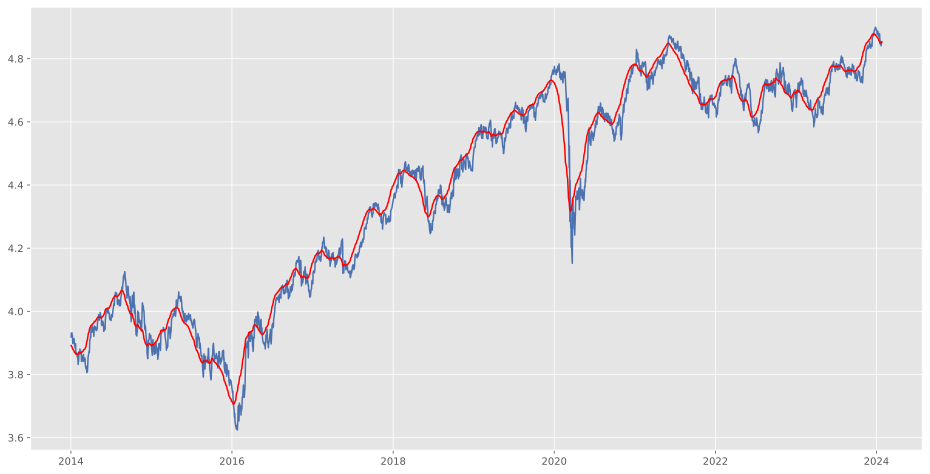

In [ ]:
df_limpo_log_exponential_decay = df_limpo_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_limpo_log)
plt.plot(df_limpo_log_exponential_decay, color='red')

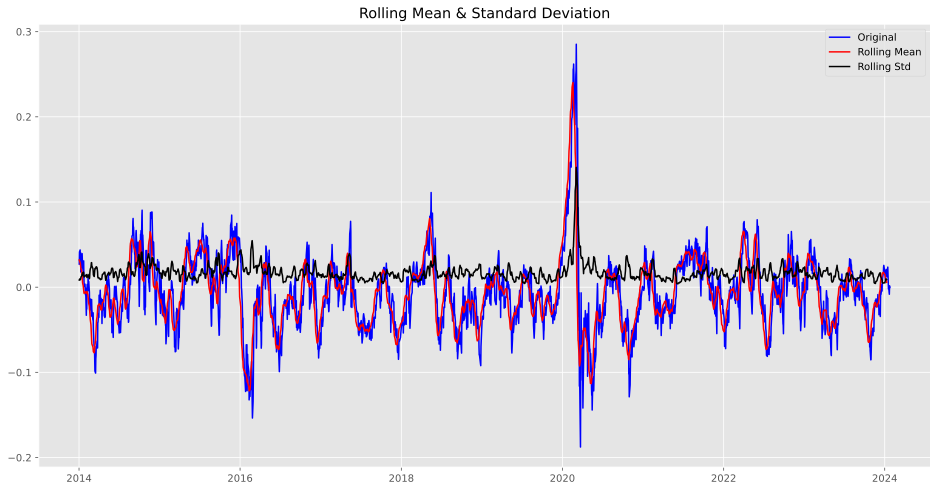

Results of Dickey Fuller Test:
Test Statistic                   -7.52
p-value                           0.00
#Lags Used                        7.00
Number of Observations Used   2,486.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


In [ ]:
# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
df_limpo_log_minus_df_limpo_log_exponential_decay = df_limpo_log - df_limpo_log_exponential_decay
test_stationarity(df_limpo_log_minus_df_limpo_log_exponential_decay)

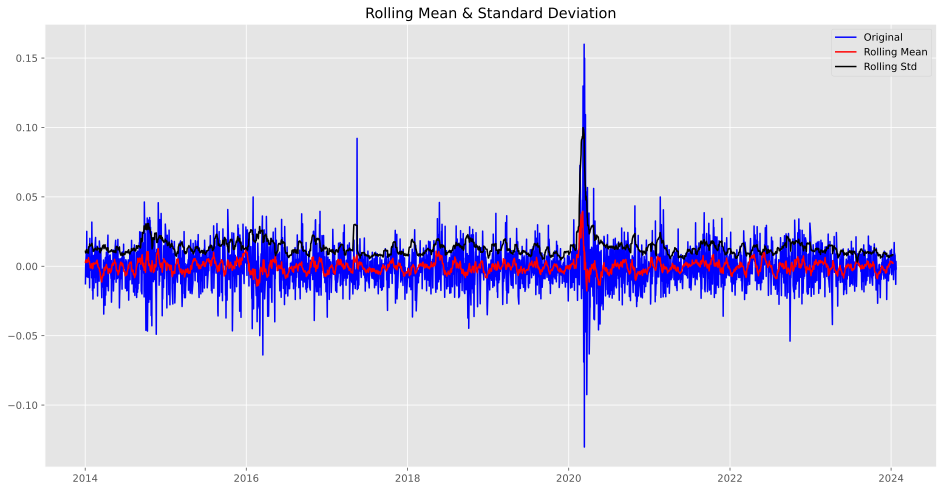

Results of Dickey Fuller Test:
Test Statistic                  -18.07
p-value                           0.00
#Lags Used                        6.00
Number of Observations Used   2,486.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


In [ ]:
df_limpo_log_minus_DiffShifting = df_limpo_log - df_limpo_log.shift() #diferença entre o valor anterior e o atual
df_limpo_log_minus_DiffShifting.dropna(inplace=True)
test_stationarity(df_limpo_log_minus_DiffShifting)

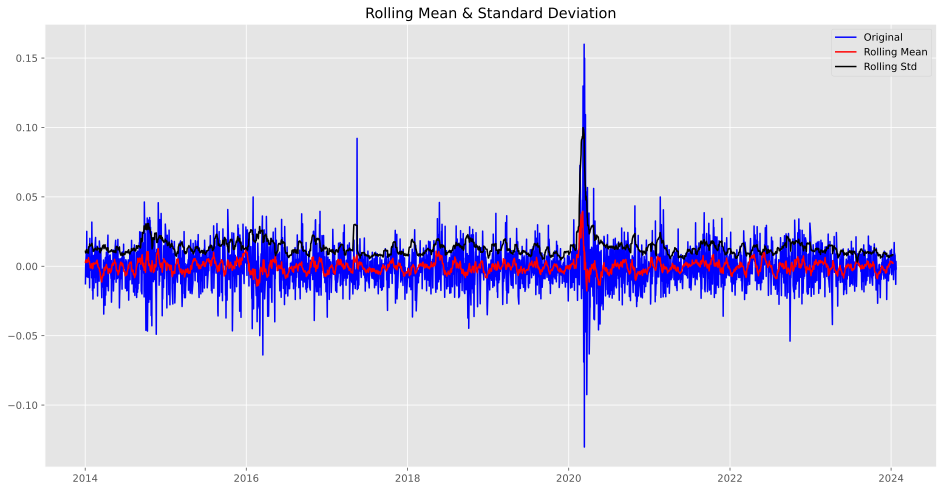

Results of Dickey Fuller Test:
Test Statistic                  -18.07
p-value                           0.00
#Lags Used                        6.00
Number of Observations Used   2,486.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


In [ ]:
df_limpo_log_minus_DiffShifting.dropna(inplace=True)
test_stationarity(df_limpo_log_minus_DiffShifting)

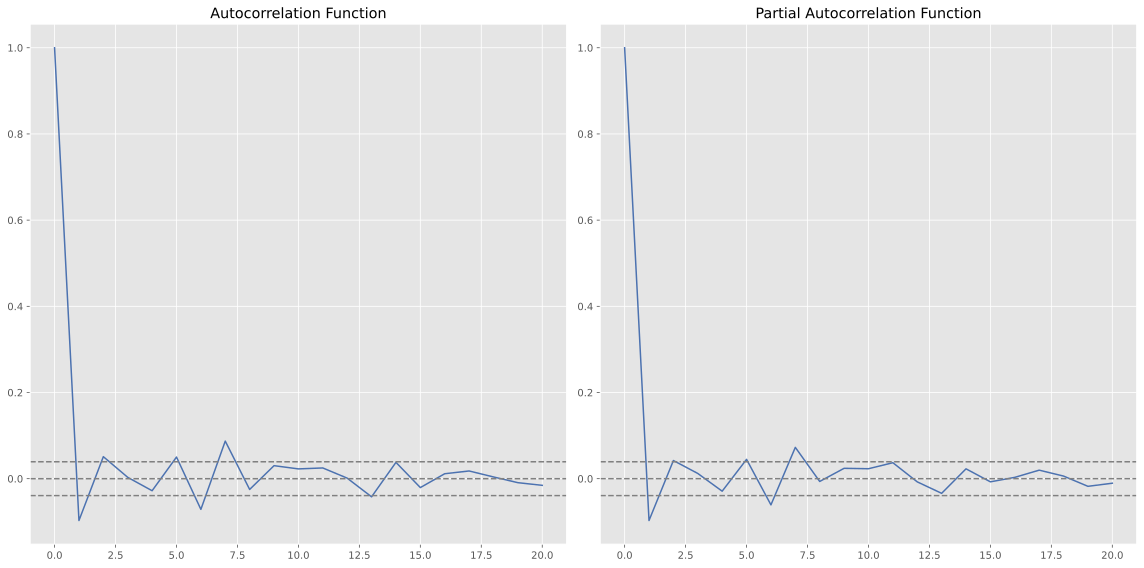

In [ ]:
lag_acf = acf(df_limpo_log_minus_DiffShifting, nlags=20)
lag_pacf = pacf(df_limpo_log_minus_DiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_limpo_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_limpo_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_limpo_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_limpo_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

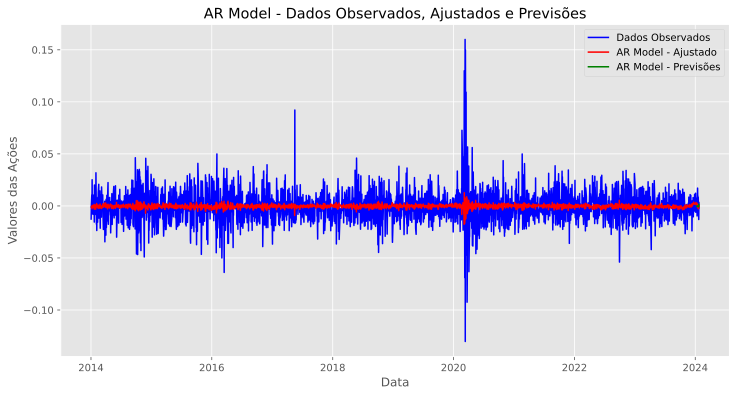

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Configuração do modelo ARIMA
p = 2
d = 1
q = 2

# Ajuste do modelo ARIMA
model = ARIMA(df_limpo_log_minus_DiffShifting['ultimo'], order=(p, d, q))
results_AR = model.fit()

# Previsões
forecast_steps = 10  # Ajuste conforme necessário
forecast = results_AR.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df_limpo_log_minus_DiffShifting.index.max(), periods=forecast_steps + 1, freq=df_limpo_log_minus_DiffShifting.index.to_series().diff().mean())

# Plotagem dos resultados
plt.figure(figsize=(12, 6))
plt.plot(df_limpo_log_minus_DiffShifting.index, df_limpo_log_minus_DiffShifting['ultimo'], color="blue", label='Dados Observados')
plt.plot(df_limpo_log_minus_DiffShifting.index, results_AR.fittedvalues, color='red', label='AR Model - Ajustado')
plt.plot(forecast_index[1:], forecast.predicted_mean, color='green', label='AR Model - Previsões')
plt.title('AR Model - Dados Observados, Ajustados e Previsões')
plt.xlabel('Data')
plt.ylabel('Valores das Ações')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = df_limpo_log_minus_DiffShifting.index

# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = df_limpo_log_minus_DiffShifting['ultimo'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(df_limpo_log_minus_DiffShifting['ultimo'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 50.49%


# prophet pro

Testando o modelo com prophet 🔮
O prophet é uma ferramenta de previsão para séries temporais desenvolvida pelo Facebook. O Prophet é especialmente projetado para lidar com séries temporais que possuem padrões sazonais fortes e vários pontos de mudança.

O Prophet é um vidente, capaz de entender e prever tendências, sazonalidades e feriados.🔮 Mágico né?

O Prophet se destaca em sua capacidade de lidar com dados faltantes, tendências que mudam ao longo do tempo e até mesmo feriados! Ele foi projetado para ser flexível e intuitivo, tornando a previsão de séries temporais uma tarefa mais simples, mesmo para aqueles que não são especialistas em estatística.

In [ ]:
# Use a função download para obter os dados
df = df_limpo.copy()
df['ds'] = df.index
df['y'] = df['ultimo']
df = df[['ds', 'y']].reset_index(drop=True)
df.head()

,ds,y
0,2024-01-25,128.06
1,2024-01-24,127.82
2,2024-01-23,128.26
3,2024-01-22,126.60
4,2024-01-19,127.64


Seprando os dados em treino e teste

In [ ]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1995, 2)
testing data size : (499, 2)


In [ ]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnaqv5cn0/wkgsl19r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnaqv5cn0/dbmqm24t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31058', 'data', 'file=/tmp/tmpnaqv5cn0/wkgsl19r.json', 'init=/tmp/tmpnaqv5cn0/dbmqm24t.json', 'output', 'file=/tmp/tmpnaqv5cn0/prophet_modelkut6cu9w/prophet_model-20240127220503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:05:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:05:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-02,49.63,41.93,58.04,49.63,49.63,0.30,0.30,0.30,-1.00,...,-0.36,-0.36,-0.36,1.66,1.66,1.66,0.00,0.00,0.00,49.93
1,2014-01-03,49.66,43.87,58.68,49.66,49.66,0.84,0.84,0.84,-1.00,...,0.03,0.03,0.03,1.81,1.81,1.81,0.00,0.00,0.00,50.50
2,2014-01-06,49.74,43.20,58.60,49.74,49.74,1.16,1.16,1.16,-1.00,...,-0.05,-0.05,-0.05,2.22,2.22,2.22,0.00,0.00,0.00,50.91
3,2014-01-08,49.80,44.02,58.92,49.80,49.80,1.42,1.42,1.42,-1.00,...,-0.02,-0.02,-0.02,2.45,2.45,2.45,0.00,0.00,0.00,51.22
4,2014-01-09,49.83,43.33,58.16,49.83,49.83,1.18,1.18,1.18,-1.00,...,-0.36,-0.36,-0.36,2.54,2.54,2.54,0.00,0.00,0.00,51.01


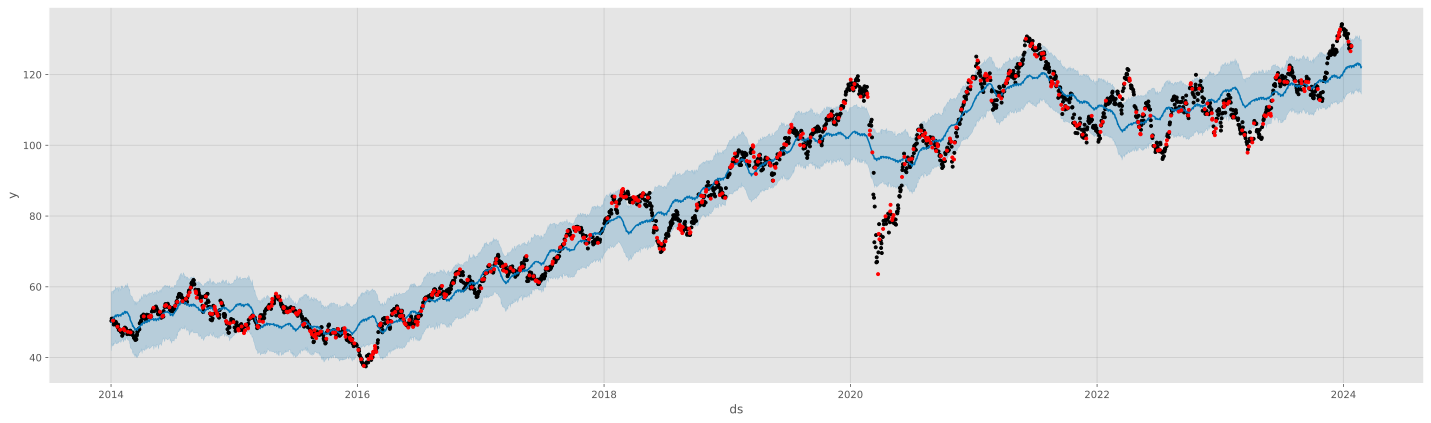

In [ ]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [ ]:
import plotly.graph_objects as go

# Criar uma figura para o gráfico
fig = go.Figure()

# Adicionar a série temporal prevista ao gráfico
fig.add_trace(go.Scatter(x=previsao['ds'], y=previsao['yhat'], mode='lines', name='Previsão'))

# Adicionar os pontos de teste ao gráfico
fig.add_trace(go.Scatter(x=test_data['ds'], y=test_data['y'], mode='markers', marker=dict(color='red'), name='Dados de Teste'))

# Layout do gráfico
fig.update_layout(title='Previsão do Modelo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  showlegend=True,
                  xaxis=dict(rangeslider=dict(visible=True), type='date'))

# Exibir o gráfico
fig.show()


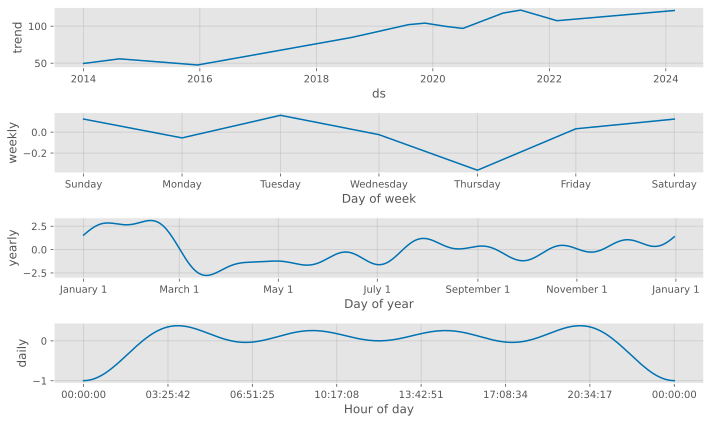

In [ ]:
modelo.plot_components(previsao, figsize=(10,6));

Adicionando Changepoints no modelo

O prophet permite adicionar pontos de mudanças na série temporal, o que nos permite identificar em quais datas ocorrem possíveis mudanças.

In [ ]:
from prophet.plot import add_changepoints_to_plot

modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnaqv5cn0/6xp_ofua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnaqv5cn0/d9vogmmj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=466', 'data', 'file=/tmp/tmpnaqv5cn0/6xp_ofua.json', 'init=/tmp/tmpnaqv5cn0/d9vogmmj.json', 'output', 'file=/tmp/tmpnaqv5cn0/prophet_modelj3u_mm2h/prophet_model-20240127220506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:05:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-02,53.07,44.18,63.79,53.07,53.07,1.38,1.38,1.38,0.16,0.16,0.16,1.22,1.22,1.22,0.00,0.00,0.00,54.45
1,2014-01-03,53.06,45.52,64.52,53.06,53.06,1.97,1.97,1.97,0.61,0.61,0.61,1.35,1.35,1.35,0.00,0.00,0.00,55.03
2,2014-01-06,53.03,45.71,65.12,53.03,53.03,2.34,2.34,2.34,0.59,0.59,0.59,1.75,1.75,1.75,0.00,0.00,0.00,55.37
3,2014-01-08,53.01,44.87,65.08,53.01,53.01,2.62,2.62,2.62,0.65,0.65,0.65,1.98,1.98,1.98,0.00,0.00,0.00,55.63
4,2014-01-09,53.00,45.62,65.29,53.00,53.00,2.23,2.23,2.23,0.16,0.16,0.16,2.07,2.07,2.07,0.00,0.00,0.00,55.23


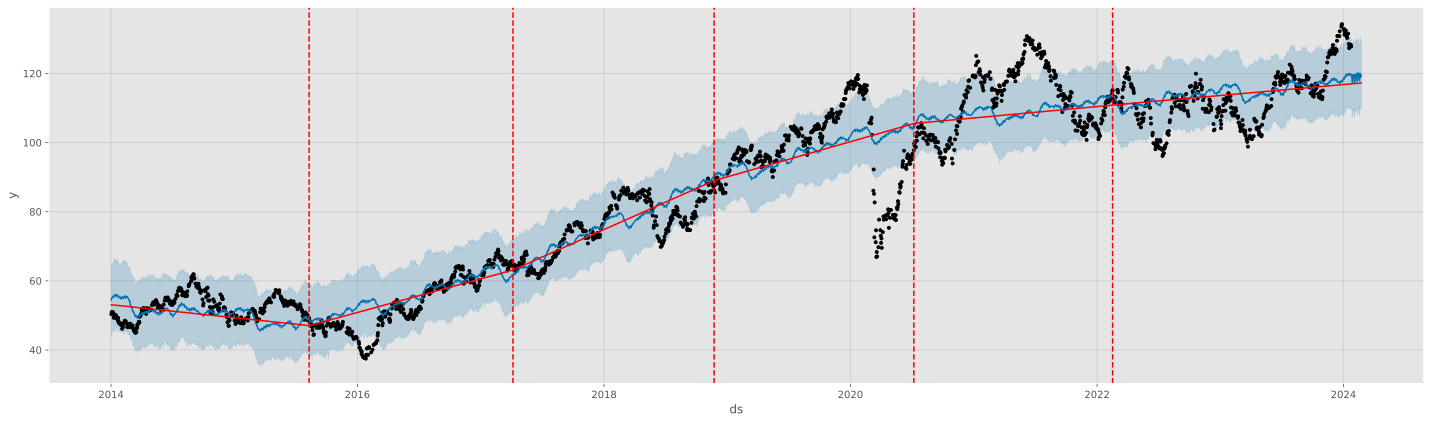

In [ ]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

In [ ]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 5.39%


Cross validation
Para concluir o modelo do Prophet, tentei fazer a validação cruzada para testar dados que nunca foram vistos pelo modelo antes.

Observe que no resultado da validação cruzada temos os valores de yhat, yhat_lower, yhat_upper e o ponto de corte. O objetivo da validação cruzada é medir o erro de predição, selecionando assim pontos de corte e para cada um desses pontos o modelo é ajustado utilizando dados apenas até aquele ponto de corte.

In [ ]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 15 forecasts with cutoffs between 2016-03-01 00:00:00 and 2023-01-24 00:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnaqv5cn0/tl07wax1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnaqv5cn0/xxpl8s9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52645', 'data', 'file=/tmp/tmpnaqv5cn0/tl07wax1.json', 'init=/tmp/tmpnaqv5cn0/xxpl8s9w.json', 'output', 'file=/tmp/tmpnaqv5cn0/prophet_modelbumfndzz/prophet_model-20240127220508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:05:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:05:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnaqv5cn0/y6k530k4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnaqv5cn0/0e3odypd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv['cutoff'].unique()

array(['2016-03-01T00:00:00.000000000', '2016-08-28T00:00:00.000000000',
       '2017-02-24T00:00:00.000000000', '2017-08-23T00:00:00.000000000',
       '2018-02-19T00:00:00.000000000', '2018-08-18T00:00:00.000000000',
       '2019-02-14T00:00:00.000000000', '2019-08-13T00:00:00.000000000',
       '2020-02-09T00:00:00.000000000', '2020-08-07T00:00:00.000000000',
       '2021-02-03T00:00:00.000000000', '2021-08-02T00:00:00.000000000',
       '2022-01-29T00:00:00.000000000', '2022-07-28T00:00:00.000000000',
       '2023-01-24T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,74.34,8.62,5.93,0.07,0.05,0.07,0.43
1,38 days,83.57,9.14,6.10,0.07,0.05,0.07,0.44
2,39 days,92.13,9.60,6.28,0.08,0.05,0.07,0.43
3,40 days,101.71,10.09,6.48,0.08,0.05,0.08,0.43
4,41 days,101.87,10.09,6.47,0.08,0.05,0.08,0.43
...,...,...,...,...,...,...,...,...
324,361 days,417.71,20.44,17.62,0.17,0.16,0.18,0.45
325,362 days,412.86,20.32,17.51,0.17,0.15,0.18,0.45
326,363 days,412.85,20.32,17.52,0.17,0.15,0.18,0.46
327,364 days,417.79,20.44,17.62,0.17,0.16,0.18,0.46


In [ ]:
import pandas as pd

# Gerar datas para os próximos 90 dias
data_futuro = pd.date_range(start=df['ds'].max(), periods=90, freq='D')[1:]
data_futuro = pd.DataFrame(data_futuro, columns=['ds'])

# Fazer previsões para os próximos 90 dias
previsao_futuro = modelo.predict(data_futuro)

# Selecionar as colunas relevantes
tabela_previsao = previsao_futuro[['ds', 'yhat']].rename(columns={'yhat': 'previsao'})

# Exibir a tabela
print(tabela_previsao)

           ds  previsao
0  2024-01-26    122.35
1  2024-01-27    122.45
2  2024-01-28    122.46
3  2024-01-29    122.31
4  2024-01-30    122.55
..        ...       ...
84 2024-04-19    119.94
85 2024-04-20    120.06
86 2024-04-21    120.09
87 2024-04-22    119.94
88 2024-04-23    120.18

[89 rows x 2 columns]


In [ ]:
# Configurar o pandas para exibir todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Exibir a tabela de previsão
print(tabela_previsao)

# Restaurar as opções padrão do pandas após a exibição
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


           ds  previsao
0  2024-01-26    122.35
1  2024-01-27    122.45
2  2024-01-28    122.46
3  2024-01-29    122.31
4  2024-01-30    122.55
5  2024-01-31    122.40
6  2024-02-01    122.11
7  2024-02-02    122.56
8  2024-02-03    122.71
9  2024-02-04    122.77
10 2024-02-05    122.66
11 2024-02-06    122.94
12 2024-02-07    122.82
13 2024-02-08    122.54
14 2024-02-09    123.00
15 2024-02-10    123.14
16 2024-02-11    123.18
17 2024-02-12    123.02
18 2024-02-13    123.25
19 2024-02-14    123.06
20 2024-02-15    122.70
21 2024-02-16    123.05
22 2024-02-17    123.07
23 2024-02-18    122.99
24 2024-02-19    122.70
25 2024-02-20    122.78
26 2024-02-21    122.44
27 2024-02-22    121.92
28 2024-02-23    122.12
29 2024-02-24    122.00
30 2024-02-25    121.77
31 2024-02-26    121.35
32 2024-02-27    121.31
33 2024-02-28    120.86
34 2024-02-29    120.25
35 2024-03-01    120.38
36 2024-03-02    120.20
37 2024-03-03    119.93
38 2024-03-04    119.50
39 2024-03-05    119.47
40 2024-03-06   